# Modelación y Simulación - Laboratorio 1
+ Ana Laura Tschen 221645
+ Sebastian Garcia 22291

## 1. Tres refinerías con capacidades diarias de 6, 5 y 8 millones de galones, respectivamente, abastecen a tres áreas de distribución con demandas diarias de 4, 8 y 7 millones de galones, respectivamente. La gasolina se transporta a las tres áreas de distribución a través de una red de oleoductos. El costo de transporte es de $0.10 por 1000 galones por kilómetro de oleoducto. En la tabla 1 se presenta la distancia en kilómetros entre las refinerías y las áreas de distribución. La refinería 1 no está conectada al área de distribución 3.
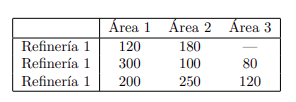

### (a) Formular el modelo de transporte asociado.

Se definirá $I$ como las refinerías y $J$ como las áreas. Donde $I={1,2,3}$ y $J={1,2,3}$

Las distancias se definiran como $d_{ij}$ utilizando km como unidades.

Los galones por dia enviados de la refineria $i$ al area $j$ se definirá como $x_{ij} \geq 0$

Para realizar la conversión del costo, se hará lo siguiente:
$$ 0.10(dolares/1000 gal*km)*\frac{10^{6}gal}{1000gal}=100 dolares/(M de gal)*km$$

Luego $c_{ij}=100d_{ij}$ si el arco existe. Si no hay oleoducto no se define $x_13$



\begin{aligned}
\min\ & \sum_{i\in I}\sum_{j\in J} c_{ij}\,x_{ij}
      \quad\text{con}\quad c_{ij}=100\,d_{ij} \\
\text{s.a. }\
& \sum_{j\in J} x_{ij} = s_i, && \forall i\in I \quad \text{(oferta)}\\
& \sum_{i\in I} x_{ij} = d_j, && \forall j\in J \quad \text{(demanda)}\\
& x_{ij} \ge 0, && \forall (i,j)\in A
\end{aligned}




En donde $s=(6,5,8)$, $d=(4,8,7)$ (en millones de galones), y $A$ es el conjunto de arcos permitidos, para todos menos $(1,3)$.

### (b) Usando JuMP o Pupl, determine el programa de envíos óptimo en la red de distribución.


In [1]:
import Pkg
Pkg.add(["JuMP","HiGHS","DataFrames","PrettyTables"])

    Updating registry at `C:\Users\alambre1\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\alambre1\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\alambre1\.julia\environments\v1.11\Manifest.toml`


In [2]:
using JuMP, HiGHS, DataFrames, PrettyTables

In [4]:
I = ["R1","R2","R3"]
J = ["A1","A2","A3"]

D = Dict(
    ("R1","A1") => 120, ("R1","A2") => 180,
    ("R2","A1") => 300, ("R2","A2") => 100, ("R2","A3") => 80,
    ("R3","A1") => 200, ("R3","A2") => 250, ("R3","A3") => 120
)

s = Dict("R1"=>6.0, "R2"=>5.0, "R3"=>8.0)
d = Dict("A1"=>4.0, "A2"=>8.0, "A3"=>7.0)

A = collect(keys(D))
c = Dict(a => 100.0 * D[a] for a in A)   

model = Model(HiGHS.Optimizer)
@variable(model, x[a in A] >= 0)

@constraint(model, [i in I], sum(x[(i,j)] for j in J if (i,j) in A) == s[i])
@constraint(model, [j in J], sum(x[(i,j)] for i in I if (i,j) in A) == d[j])

@objective(model, Min, sum(c[a] * x[a] for a in A))
optimize!(model)

ship = Dict(a => value(x[a]) for a in A)
total_cost = objective_value(model)

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
LP   has 6 rows; 8 cols; 16 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [8e+03, 3e+04]
  Bound  [0e+00, 0e+00]
  RHS    [4e+00, 8e+00]
Presolving model
4 rows, 6 cols, 12 nonzeros  0s
Dependent equations search running on 4 equations with time limit of 1000.00s
Dependent equations search removed 1 rows and 3 nonzeros in 0.00s (limit = 1000.00s)
3 rows, 6 cols, 9 nonzeros  0s
Presolve : Reductions: rows 3(-3); columns 6(-2); elements 9(-7)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
          3     2.4300000000e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model status        : Optimal
Simplex   iterations: 3
Objective value     :  2.4300000000e+05
P-D objective error :  0.0000000000e+00
HiGHS run time      :          0.00


243000.0

In [5]:
mat = [
    get(ship, ("R1","A1"), 0.0)  get(ship, ("R1","A2"), 0.0)  0.0;
    get(ship, ("R2","A1"), 0.0)  get(ship, ("R2","A2"), 0.0)  get(ship, ("R2","A3"), 0.0);
    get(ship, ("R3","A1"), 0.0)  get(ship, ("R3","A2"), 0.0)  get(ship, ("R3","A3"), 0.0)
]
df = DataFrame(Refinería = I, A1 = mat[:,1], A2 = mat[:,2], A3 = mat[:,3])

println("Plan óptimo (millones de galones/día):")
pretty_table(df; formatters = ft_printf("%.0f"))
println("Costo total óptimo = \$", round(total_cost; digits=0))

Plan óptimo (millones de galones/día):
┌───────────┬─────────┬─────────┬─────────┐
│ Refinería │      A1 │      A2 │      A3 │
│    String │ Float64 │ Float64 │ Float64 │
├───────────┼─────────┼─────────┼─────────┤
│        R1 │       4 │       2 │       0 │
│        R2 │       0 │       5 │       0 │
│        R3 │       0 │       1 │       7 │
└───────────┴─────────┴─────────┴─────────┘
Costo total óptimo = $243000.0


Respuesta: El plan óptimo reparte los envíos así (en millones de galones/día): R1→A1 = 4, R1→A2 = 2, R2→A2 = 5, R3→A2 = 1 y R3→A3 = 7 (los demás flujos son 0). Con esto:

+ Por lo que se satisface exactamente la demanda: A1=4, A2=8 (2 de R1 + 5 de R2 + 1 de R3), A3=7 (todo de R3).

+ Se usa toda la oferta: R1=6 (4+2), R2=5 (todo a A2), R3=8 (1 a A2 y 7 a A3).

+ No se envía de R1→A3 (arco inexistente), y se priorizan los tramos más baratos: R2→A2 (100 km) y R3→A3 (120 km). R1 divide entre A1 (120 km) y A2 (180 km) para completar A2.

El costo total mínimo resultante es $243,000 por día. El modelo concentra el flujo en las rutas de menor costo y evita las conexiones ausentes, cumpliendo oferta y demanda sin excedentes.


### (c) Suponga ahora que la demanda diaria en el área 3 disminuye a 4 millones de galones. La producción excedente en las refinerías 1 y 2 se envía a otras áreas de distribución por medio de camiones. El costo de transporte por 100 galones es de $1.50 desde la refinería 1 y de $2.20 desde la refinería 2. La refinería 3 puede enviar su producción excedente a otros procesos químicos dentro de la planta. Formule y resuelva de nuevo el programa óptimo de envíos.


La formulación del problema sería la siguiente:

Se da una baja de la demanda de A3 a 4 y el excedente total es de 3 millones de galones por día. Este excedente se va a un dump y se absorbe. Esto permite que cada refinería pueda enviar lo siguiente:
+ R1 por camión a $1.50 / 100 gal = $15,000 por millón.
+ R2 por camión a $2.20 / 100 gal = $22,000 por millón.
+ R3 a otros procesos internos ($0 por millón). Los oleoductos y costos por km se mantienen, y R1→A3 sigue prohibido.

\begin{aligned}
\text{Conjuntos: }& I=\{1,2,3\},\quad J'=\{1,2,3,D\}.\\
\text{Datos: }& s=(6,5,8),\quad d'=(4,8,4,3),\\
& c_{ij}=100\,d_{ij}\ \text{si } j\in\{1,2,3\},\quad
c_{1D}=15000,\ c_{2D}=22000,\ c_{3D}=0.\\
\text{Vars: }& x_{ij}\ge 0\ \text{para }(i,j)\in A'\ \text{(arcos permitidos, sin }(1,3)\text{)}.\\[2mm]
\min\ & \sum_{(i,j)\in A'} c_{ij}\,x_{ij}\\
\text{s.a. }&
\sum_{j\in J'} x_{ij} = s_i,\quad \forall i\in I \quad \text{(oferta)}\\
&\sum_{i\in I} x_{ij} = d'_j,\quad \forall j\in J' \quad \text{(demanda)}\\
&x_{ij}\ge 0,\quad \forall(i,j)\in A'.
\end{aligned}

In [6]:
I = ["R1","R2","R3"]
J2 = ["A1","A2","A3","DUMP"]

D = Dict(
    ("R1","A1") => 120, ("R1","A2") => 180,
    ("R2","A1") => 300, ("R2","A2") => 100, ("R2","A3") => 80,
    ("R3","A1") => 200, ("R3","A2") => 250, ("R3","A3") => 120
)

s = Dict("R1"=>6.0, "R2"=>5.0, "R3"=>8.0)
d2 = Dict("A1"=>4.0, "A2"=>8.0, "A3"=>4.0, "DUMP"=>3.0) #definicion de nuestro dump

A2 = Set([(i,j) for i in I for j in ["A1","A2","A3"] if (i,j) != ("R1","A3")])
A2 = union(A2, Set([(i,"DUMP") for i in I]))

#definicion de costos
c2 = Dict{Tuple{String,String},Float64}()
for (i,j) in A2
    if j == "DUMP"
        c2[(i,j)] = i=="R1" ? 15000.0 : (i=="R2" ? 22000.0 : 0.0)
    else
        c2[(i,j)] = 100.0 * D[(i,j)]
    end
end

model2 = Model(HiGHS.Optimizer)
@variable(model2, x[a in A2] >= 0)

@constraint(model2, [i in I], sum(x[(i,j)] for j in J2 if (i,j) in A2) == s[i])
@constraint(model2, [j in J2], sum(x[(i,j)] for i in I if (i,j) in A2) == d2[j])

@objective(model2, Min, sum(c2[a]*x[a] for a in A2))
optimize!(model2)

ship2 = Dict(a => value(x[a]) for a in A2)
total_cost2 = objective_value(model2)

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
LP   has 7 rows; 11 cols; 22 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [8e+03, 3e+04]
  Bound  [0e+00, 0e+00]
  RHS    [3e+00, 8e+00]
Presolving model
6 rows, 10 cols, 20 nonzeros  0s
Dependent equations search running on 6 equations with time limit of 1000.00s
Dependent equations search removed 1 rows and 4 nonzeros in 0.00s (limit = 1000.00s)
5 rows, 10 cols, 16 nonzeros  0s
Presolve : Reductions: rows 5(-2); columns 10(-1); elements 16(-6)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
          5     2.0700000000e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model status        : Optimal
Simplex   iterations: 5
Objective value     :  2.0700000000e+05
P-D objective error :  0.0000000000e+00
HiGHS run time      :          0.0

207000.0

In [7]:
df2 = DataFrame(
    Refinería = I,
    A1   = [get(ship2, ("R1","A1"), 0.0), get(ship2, ("R2","A1"), 0.0), get(ship2, ("R3","A1"), 0.0)],
    A2   = [get(ship2, ("R1","A2"), 0.0), get(ship2, ("R2","A2"), 0.0), get(ship2, ("R3","A2"), 0.0)],
    A3   = [0.0, get(ship2, ("R2","A3"), 0.0), get(ship2, ("R3","A3"), 0.0)],
    DUMP = [get(ship2, ("R1","DUMP"), 0.0), get(ship2, ("R2","DUMP"), 0.0), get(ship2, ("R3","DUMP"), 0.0)]
)

println("Plan óptimo (millones de galones/día) con DUMP:")
pretty_table(df2; formatters = ft_printf("%.0f"))
println("Costo total óptimo = \$", round(total_cost2; digits=0))

Plan óptimo (millones de galones/día) con DUMP:
┌───────────┬─────────┬─────────┬─────────┬─────────┐
│ Refinería │      A1 │      A2 │      A3 │    DUMP │
│    String │ Float64 │ Float64 │ Float64 │ Float64 │
├───────────┼─────────┼─────────┼─────────┼─────────┤
│        R1 │       4 │       2 │       0 │       0 │
│        R2 │       0 │       5 │       0 │       0 │
│        R3 │       0 │       1 │       4 │       3 │
└───────────┴─────────┴─────────┴─────────┴─────────┘
Costo total óptimo = $207000.0


Respuesta:  El excedente de 3 millones se envía íntegramente desde R3 al nodo DUMP porque su costo es 0, mientras que enviar excedentes desde R1 o R2 por camión sería más caro ($15,000 y $22,000 por millón). Se mantienen los oleoductos de menor costo para satisfacer A1 y A2 (R2→A2 y R1→A1/A2), y A3 se abastece parcialmente desde R3 (4 millones). De este modo, se cumplen todas las ofertas y demandas al menor costo posible.